# Our final model

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  7 26800    7  1919    0     0   1411      0  0:00:18  0:00:01  0:00:17  1411
100 26800  100 26800    0     0  18431      0  0:00:01  0:00:01 --:--:-- 18431


In [9]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [10]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [11]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000
std,17.604333,17.191727,15.463152
min,68.000000,9.000000,-21.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,102.000000,84.000000


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [15]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
                
def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [16]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

num_categories = 3
dropout = 0.6
model = keras.Sequential()

model.add(Dense(100, name='hidden1', input_dim=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
__________

### We also limit the number of epochs further to 2000 (because we have seen that after that nothing good is going to happen)

In [17]:
BATCH_SIZE=1000
EPOCHS = 2000

%time history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/2000
720/720 [==============================] - 1s 1ms/step - loss: 1.8481 - acc: 0.2903 - val_loss: 8.3798 - val_acc: 0.3333
Epoch 2/2000
720/720 [==============================] - 0s 32us/step - loss: 1.6713 - acc: 0.3222 - val_loss: 7.7923 - val_acc: 0.3333
Epoch 3/2000
720/720 [==============================] - 0s 11us/step - loss: 1.7103 - acc: 0.3181 - val_loss: 6.7432 - val_acc: 0.3333
Epoch 4/2000
720/720 [==============================] - 0s 17us/step - loss: 1.6463 - acc: 0.3556 - val_loss: 5.1088 - val_acc: 0.3333
Epoch 5/2000
720/720 [==============================] - 0s 28us/step - loss: 1.5849 - acc: 0.3667 - val_loss: 3.5979 - val_acc: 0.3333
Epoch 6/2000
720/720 [==============================] - 0s 17us/step - loss: 1.5363 - acc: 0.3944 - val_loss: 2.4393 - val_acc: 0.3389
Epoch 7/2000
720/720 [==============================] - 0s 11us/step - loss: 1.5042 - acc: 0.3681 - val_loss: 2.1642 - val_acc: 0.2389
Epoch 8/20

Epoch 61/2000
720/720 [==============================] - 0s 11us/step - loss: 0.9033 - acc: 0.6347 - val_loss: 2.7048 - val_acc: 0.4667
Epoch 62/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8716 - acc: 0.6236 - val_loss: 2.6808 - val_acc: 0.4722
Epoch 63/2000
720/720 [==============================] - 0s 11us/step - loss: 0.9016 - acc: 0.6028 - val_loss: 2.6556 - val_acc: 0.4778
Epoch 64/2000
720/720 [==============================] - 0s 17us/step - loss: 0.9499 - acc: 0.5708 - val_loss: 2.6281 - val_acc: 0.4778
Epoch 65/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8864 - acc: 0.6028 - val_loss: 2.5998 - val_acc: 0.4889
Epoch 66/2000
720/720 [==============================] - 0s 17us/step - loss: 0.9309 - acc: 0.5875 - val_loss: 2.5721 - val_acc: 0.4889
Epoch 67/2000
720/720 [==============================] - 0s 11us/step - loss: 0.9322 - acc: 0.5972 - val_loss: 2.5462 - val_acc: 0.4833
Epoch 68/2000
720/720 [=========================

Epoch 122/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7867 - acc: 0.6625 - val_loss: 1.6626 - val_acc: 0.4833
Epoch 123/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8031 - acc: 0.6681 - val_loss: 1.6454 - val_acc: 0.5000
Epoch 124/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7814 - acc: 0.6819 - val_loss: 1.6279 - val_acc: 0.5000
Epoch 125/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8135 - acc: 0.6444 - val_loss: 1.6088 - val_acc: 0.4944
Epoch 126/2000
720/720 [==============================] - 0s 28us/step - loss: 0.7766 - acc: 0.6722 - val_loss: 1.5890 - val_acc: 0.5056
Epoch 127/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7928 - acc: 0.6667 - val_loss: 1.5688 - val_acc: 0.5111
Epoch 128/2000
720/720 [==============================] - 0s 28us/step - loss: 0.7366 - acc: 0.6889 - val_loss: 1.5500 - val_acc: 0.5111
Epoch 129/2000
720/720 [=================

Epoch 182/2000
720/720 [==============================] - 0s 28us/step - loss: 0.7385 - acc: 0.6889 - val_loss: 0.9231 - val_acc: 0.6111
Epoch 183/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7767 - acc: 0.6722 - val_loss: 0.9124 - val_acc: 0.6056
Epoch 184/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7161 - acc: 0.7208 - val_loss: 0.9034 - val_acc: 0.6056
Epoch 185/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7360 - acc: 0.7028 - val_loss: 0.8942 - val_acc: 0.6111
Epoch 186/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7523 - acc: 0.6986 - val_loss: 0.8862 - val_acc: 0.6222
Epoch 187/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7692 - acc: 0.6750 - val_loss: 0.8790 - val_acc: 0.6333
Epoch 188/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7594 - acc: 0.6875 - val_loss: 0.8728 - val_acc: 0.6333
Epoch 189/2000
720/720 [=================

Epoch 242/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7234 - acc: 0.7097 - val_loss: 0.6643 - val_acc: 0.7333
Epoch 243/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6978 - acc: 0.7042 - val_loss: 0.6627 - val_acc: 0.7278
Epoch 244/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6926 - acc: 0.7208 - val_loss: 0.6611 - val_acc: 0.7222
Epoch 245/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7358 - acc: 0.7028 - val_loss: 0.6587 - val_acc: 0.7222
Epoch 246/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7297 - acc: 0.7083 - val_loss: 0.6561 - val_acc: 0.7222
Epoch 247/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7317 - acc: 0.7069 - val_loss: 0.6532 - val_acc: 0.7278
Epoch 248/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7040 - acc: 0.7194 - val_loss: 0.6502 - val_acc: 0.7278
Epoch 249/2000
720/720 [=================

Epoch 302/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7238 - acc: 0.7403 - val_loss: 0.5895 - val_acc: 0.7889
Epoch 303/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7472 - acc: 0.6944 - val_loss: 0.5897 - val_acc: 0.7889
Epoch 304/2000
720/720 [==============================] - 0s 0us/step - loss: 0.6984 - acc: 0.7153 - val_loss: 0.5895 - val_acc: 0.7889
Epoch 305/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7035 - acc: 0.7292 - val_loss: 0.5893 - val_acc: 0.7889
Epoch 306/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7074 - acc: 0.7181 - val_loss: 0.5892 - val_acc: 0.7889
Epoch 307/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6973 - acc: 0.7153 - val_loss: 0.5894 - val_acc: 0.7889
Epoch 308/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7179 - acc: 0.7125 - val_loss: 0.5894 - val_acc: 0.7889
Epoch 309/2000
720/720 [===================

Epoch 362/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7116 - acc: 0.7181 - val_loss: 0.5789 - val_acc: 0.7667
Epoch 363/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6790 - acc: 0.7417 - val_loss: 0.5782 - val_acc: 0.7667
Epoch 364/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7152 - acc: 0.7111 - val_loss: 0.5779 - val_acc: 0.7667
Epoch 365/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6965 - acc: 0.7264 - val_loss: 0.5776 - val_acc: 0.7667
Epoch 366/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6877 - acc: 0.7042 - val_loss: 0.5776 - val_acc: 0.7611
Epoch 367/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6765 - acc: 0.7194 - val_loss: 0.5774 - val_acc: 0.7611
Epoch 368/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6736 - acc: 0.7556 - val_loss: 0.5772 - val_acc: 0.7611
Epoch 369/2000
720/720 [=================

Epoch 422/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6792 - acc: 0.7264 - val_loss: 0.5681 - val_acc: 0.7833
Epoch 423/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6883 - acc: 0.7444 - val_loss: 0.5691 - val_acc: 0.7833
Epoch 424/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7079 - acc: 0.7264 - val_loss: 0.5704 - val_acc: 0.7833
Epoch 425/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6738 - acc: 0.7431 - val_loss: 0.5715 - val_acc: 0.7889
Epoch 426/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6940 - acc: 0.7333 - val_loss: 0.5724 - val_acc: 0.7889
Epoch 427/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6756 - acc: 0.7375 - val_loss: 0.5730 - val_acc: 0.7889
Epoch 428/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6829 - acc: 0.7319 - val_loss: 0.5735 - val_acc: 0.7889
Epoch 429/2000
720/720 [=================

Epoch 482/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6536 - acc: 0.7444 - val_loss: 0.5740 - val_acc: 0.7778
Epoch 483/2000
720/720 [==============================] - 0s 39us/step - loss: 0.6731 - acc: 0.7306 - val_loss: 0.5733 - val_acc: 0.7778
Epoch 484/2000
720/720 [==============================] - 0s 44us/step - loss: 0.6371 - acc: 0.7583 - val_loss: 0.5725 - val_acc: 0.7778
Epoch 485/2000
720/720 [==============================] - 0s 44us/step - loss: 0.6933 - acc: 0.7208 - val_loss: 0.5719 - val_acc: 0.7778
Epoch 486/2000
720/720 [==============================] - 0s 39us/step - loss: 0.6739 - acc: 0.7194 - val_loss: 0.5715 - val_acc: 0.7722
Epoch 487/2000
720/720 [==============================] - 0s 33us/step - loss: 0.6738 - acc: 0.7306 - val_loss: 0.5713 - val_acc: 0.7778
Epoch 488/2000
720/720 [==============================] - 0s 44us/step - loss: 0.6908 - acc: 0.7181 - val_loss: 0.5712 - val_acc: 0.7778
Epoch 489/2000
720/720 [=================

Epoch 542/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6495 - acc: 0.7403 - val_loss: 0.5753 - val_acc: 0.7611
Epoch 543/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6494 - acc: 0.7625 - val_loss: 0.5759 - val_acc: 0.7611
Epoch 544/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6753 - acc: 0.7250 - val_loss: 0.5765 - val_acc: 0.7611
Epoch 545/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6752 - acc: 0.7500 - val_loss: 0.5774 - val_acc: 0.7611
Epoch 546/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6326 - acc: 0.7681 - val_loss: 0.5777 - val_acc: 0.7611
Epoch 547/2000
720/720 [==============================] - 0s 33us/step - loss: 0.6397 - acc: 0.7486 - val_loss: 0.5781 - val_acc: 0.7611
Epoch 548/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6412 - acc: 0.7486 - val_loss: 0.5782 - val_acc: 0.7611
Epoch 549/2000
720/720 [=================

Epoch 602/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6228 - acc: 0.7486 - val_loss: 0.5594 - val_acc: 0.7833
Epoch 603/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6400 - acc: 0.7431 - val_loss: 0.5586 - val_acc: 0.7833
Epoch 604/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6645 - acc: 0.7389 - val_loss: 0.5576 - val_acc: 0.7778
Epoch 605/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6216 - acc: 0.7375 - val_loss: 0.5576 - val_acc: 0.7778
Epoch 606/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6646 - acc: 0.7431 - val_loss: 0.5575 - val_acc: 0.7778
Epoch 607/2000
720/720 [==============================] - 0s 39us/step - loss: 0.6448 - acc: 0.7458 - val_loss: 0.5577 - val_acc: 0.7778
Epoch 608/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6338 - acc: 0.7458 - val_loss: 0.5577 - val_acc: 0.7833
Epoch 609/2000
720/720 [=================

Epoch 662/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6373 - acc: 0.7583 - val_loss: 0.5498 - val_acc: 0.7889
Epoch 663/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6357 - acc: 0.7486 - val_loss: 0.5491 - val_acc: 0.7889
Epoch 664/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6201 - acc: 0.7417 - val_loss: 0.5492 - val_acc: 0.7889
Epoch 665/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6367 - acc: 0.7444 - val_loss: 0.5492 - val_acc: 0.7889
Epoch 666/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6382 - acc: 0.7514 - val_loss: 0.5496 - val_acc: 0.7833
Epoch 667/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6467 - acc: 0.7458 - val_loss: 0.5500 - val_acc: 0.7833
Epoch 668/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6286 - acc: 0.7542 - val_loss: 0.5504 - val_acc: 0.7778
Epoch 669/2000
720/720 [=================

Epoch 722/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6426 - acc: 0.7528 - val_loss: 0.5520 - val_acc: 0.7778
Epoch 723/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6239 - acc: 0.7653 - val_loss: 0.5534 - val_acc: 0.7722
Epoch 724/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6342 - acc: 0.7569 - val_loss: 0.5545 - val_acc: 0.7667
Epoch 725/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6307 - acc: 0.7444 - val_loss: 0.5557 - val_acc: 0.7667
Epoch 726/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6276 - acc: 0.7472 - val_loss: 0.5563 - val_acc: 0.7667
Epoch 727/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6656 - acc: 0.7250 - val_loss: 0.5573 - val_acc: 0.7667
Epoch 728/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6184 - acc: 0.7514 - val_loss: 0.5584 - val_acc: 0.7667
Epoch 729/2000
720/720 [=================

Epoch 782/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6290 - acc: 0.7694 - val_loss: 0.5531 - val_acc: 0.7778
Epoch 783/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6256 - acc: 0.7681 - val_loss: 0.5526 - val_acc: 0.7778
Epoch 784/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6380 - acc: 0.7583 - val_loss: 0.5519 - val_acc: 0.7778
Epoch 785/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6167 - acc: 0.7403 - val_loss: 0.5516 - val_acc: 0.7778
Epoch 786/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6228 - acc: 0.7750 - val_loss: 0.5517 - val_acc: 0.7722
Epoch 787/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6392 - acc: 0.7458 - val_loss: 0.5527 - val_acc: 0.7722
Epoch 788/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6291 - acc: 0.7542 - val_loss: 0.5534 - val_acc: 0.7722
Epoch 789/2000
720/720 [=================

Epoch 842/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6231 - acc: 0.7639 - val_loss: 0.5442 - val_acc: 0.7833
Epoch 843/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6435 - acc: 0.7500 - val_loss: 0.5430 - val_acc: 0.7833
Epoch 844/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6330 - acc: 0.7444 - val_loss: 0.5422 - val_acc: 0.7889
Epoch 845/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6260 - acc: 0.7444 - val_loss: 0.5413 - val_acc: 0.7944
Epoch 846/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6395 - acc: 0.7583 - val_loss: 0.5404 - val_acc: 0.7944
Epoch 847/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6412 - acc: 0.7417 - val_loss: 0.5401 - val_acc: 0.7944
Epoch 848/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6165 - acc: 0.7611 - val_loss: 0.5399 - val_acc: 0.7944
Epoch 849/2000
720/720 [=================

Epoch 902/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6275 - acc: 0.7583 - val_loss: 0.5374 - val_acc: 0.7889
Epoch 903/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6064 - acc: 0.7528 - val_loss: 0.5373 - val_acc: 0.7889
Epoch 904/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6380 - acc: 0.7708 - val_loss: 0.5368 - val_acc: 0.7944
Epoch 905/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6630 - acc: 0.7306 - val_loss: 0.5369 - val_acc: 0.7889
Epoch 906/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6022 - acc: 0.7653 - val_loss: 0.5369 - val_acc: 0.7889
Epoch 907/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6183 - acc: 0.7667 - val_loss: 0.5371 - val_acc: 0.7889
Epoch 908/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6389 - acc: 0.7444 - val_loss: 0.5382 - val_acc: 0.7889
Epoch 909/2000
720/720 [=================

Epoch 962/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5978 - acc: 0.7611 - val_loss: 0.5505 - val_acc: 0.7778
Epoch 963/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5950 - acc: 0.7764 - val_loss: 0.5501 - val_acc: 0.7778
Epoch 964/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6415 - acc: 0.7389 - val_loss: 0.5499 - val_acc: 0.7778
Epoch 965/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6203 - acc: 0.7653 - val_loss: 0.5497 - val_acc: 0.7667
Epoch 966/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6224 - acc: 0.7514 - val_loss: 0.5494 - val_acc: 0.7667
Epoch 967/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6193 - acc: 0.7708 - val_loss: 0.5488 - val_acc: 0.7722
Epoch 968/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6308 - acc: 0.7583 - val_loss: 0.5479 - val_acc: 0.7722
Epoch 969/2000
720/720 [=================

Epoch 1022/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6163 - acc: 0.7625 - val_loss: 0.5438 - val_acc: 0.7722
Epoch 1023/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6374 - acc: 0.7611 - val_loss: 0.5432 - val_acc: 0.7722
Epoch 1024/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6198 - acc: 0.7736 - val_loss: 0.5422 - val_acc: 0.7722
Epoch 1025/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6087 - acc: 0.7653 - val_loss: 0.5417 - val_acc: 0.7722
Epoch 1026/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6072 - acc: 0.7625 - val_loss: 0.5410 - val_acc: 0.7778
Epoch 1027/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6430 - acc: 0.7486 - val_loss: 0.5405 - val_acc: 0.7833
Epoch 1028/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6020 - acc: 0.7694 - val_loss: 0.5399 - val_acc: 0.7833
Epoch 1029/2000
720/720 [=========

Epoch 1082/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5987 - acc: 0.7722 - val_loss: 0.5489 - val_acc: 0.7556
Epoch 1083/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6101 - acc: 0.7722 - val_loss: 0.5495 - val_acc: 0.7556
Epoch 1084/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5958 - acc: 0.7722 - val_loss: 0.5499 - val_acc: 0.7500
Epoch 1085/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5956 - acc: 0.7736 - val_loss: 0.5493 - val_acc: 0.7500
Epoch 1086/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6118 - acc: 0.7542 - val_loss: 0.5490 - val_acc: 0.7500
Epoch 1087/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5850 - acc: 0.7806 - val_loss: 0.5484 - val_acc: 0.7500
Epoch 1088/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6198 - acc: 0.7736 - val_loss: 0.5479 - val_acc: 0.7500
Epoch 1089/2000
720/720 [=========

Epoch 1142/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6118 - acc: 0.7681 - val_loss: 0.5488 - val_acc: 0.7667
Epoch 1143/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5835 - acc: 0.7750 - val_loss: 0.5511 - val_acc: 0.7667
Epoch 1144/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5891 - acc: 0.7736 - val_loss: 0.5525 - val_acc: 0.7667
Epoch 1145/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6028 - acc: 0.7833 - val_loss: 0.5529 - val_acc: 0.7667
Epoch 1146/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6138 - acc: 0.7667 - val_loss: 0.5528 - val_acc: 0.7667
Epoch 1147/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5763 - acc: 0.7944 - val_loss: 0.5530 - val_acc: 0.7667
Epoch 1148/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5943 - acc: 0.7681 - val_loss: 0.5541 - val_acc: 0.7667
Epoch 1149/2000
720/720 [=========

Epoch 1202/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5908 - acc: 0.7708 - val_loss: 0.5508 - val_acc: 0.7722
Epoch 1203/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5916 - acc: 0.7889 - val_loss: 0.5518 - val_acc: 0.7722
Epoch 1204/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5959 - acc: 0.7792 - val_loss: 0.5521 - val_acc: 0.7667
Epoch 1205/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6033 - acc: 0.7625 - val_loss: 0.5524 - val_acc: 0.7667
Epoch 1206/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5752 - acc: 0.7847 - val_loss: 0.5527 - val_acc: 0.7667
Epoch 1207/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5993 - acc: 0.7722 - val_loss: 0.5520 - val_acc: 0.7667
Epoch 1208/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5809 - acc: 0.7667 - val_loss: 0.5512 - val_acc: 0.7667
Epoch 1209/2000
720/720 [=========

Epoch 1262/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5555 - acc: 0.7819 - val_loss: 0.5490 - val_acc: 0.7722
Epoch 1263/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6049 - acc: 0.7625 - val_loss: 0.5476 - val_acc: 0.7667
Epoch 1264/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6081 - acc: 0.7681 - val_loss: 0.5461 - val_acc: 0.7722
Epoch 1265/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5782 - acc: 0.7792 - val_loss: 0.5448 - val_acc: 0.7722
Epoch 1266/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5863 - acc: 0.7778 - val_loss: 0.5434 - val_acc: 0.7722
Epoch 1267/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6001 - acc: 0.7694 - val_loss: 0.5418 - val_acc: 0.7722
Epoch 1268/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5791 - acc: 0.7792 - val_loss: 0.5405 - val_acc: 0.7722
Epoch 1269/2000
720/720 [=========

Epoch 1322/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5844 - acc: 0.7653 - val_loss: 0.5329 - val_acc: 0.7833
Epoch 1323/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6002 - acc: 0.7764 - val_loss: 0.5339 - val_acc: 0.7778
Epoch 1324/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6046 - acc: 0.7667 - val_loss: 0.5345 - val_acc: 0.7778
Epoch 1325/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5724 - acc: 0.7722 - val_loss: 0.5352 - val_acc: 0.7833
Epoch 1326/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5788 - acc: 0.7847 - val_loss: 0.5354 - val_acc: 0.7833
Epoch 1327/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5806 - acc: 0.7694 - val_loss: 0.5359 - val_acc: 0.7778
Epoch 1328/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5916 - acc: 0.7667 - val_loss: 0.5364 - val_acc: 0.7778
Epoch 1329/2000
720/720 [=========

Epoch 1382/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6039 - acc: 0.7667 - val_loss: 0.5345 - val_acc: 0.7889
Epoch 1383/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5927 - acc: 0.7611 - val_loss: 0.5345 - val_acc: 0.7944
Epoch 1384/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5871 - acc: 0.7778 - val_loss: 0.5346 - val_acc: 0.7944
Epoch 1385/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5815 - acc: 0.7694 - val_loss: 0.5340 - val_acc: 0.7944
Epoch 1386/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5737 - acc: 0.7806 - val_loss: 0.5329 - val_acc: 0.8000
Epoch 1387/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5985 - acc: 0.7667 - val_loss: 0.5316 - val_acc: 0.7944
Epoch 1388/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6161 - acc: 0.7611 - val_loss: 0.5308 - val_acc: 0.7889
Epoch 1389/2000
720/720 [=========

Epoch 1442/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5700 - acc: 0.7819 - val_loss: 0.5348 - val_acc: 0.7889
Epoch 1443/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5717 - acc: 0.7847 - val_loss: 0.5343 - val_acc: 0.7833
Epoch 1444/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6030 - acc: 0.7861 - val_loss: 0.5341 - val_acc: 0.7889
Epoch 1445/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5829 - acc: 0.7819 - val_loss: 0.5336 - val_acc: 0.7944
Epoch 1446/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5704 - acc: 0.7903 - val_loss: 0.5331 - val_acc: 0.7944
Epoch 1447/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5906 - acc: 0.7722 - val_loss: 0.5331 - val_acc: 0.7944
Epoch 1448/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6071 - acc: 0.7681 - val_loss: 0.5332 - val_acc: 0.7944
Epoch 1449/2000
720/720 [=========

Epoch 1502/2000
720/720 [==============================] - 0s 28us/step - loss: 0.5774 - acc: 0.7819 - val_loss: 0.5320 - val_acc: 0.7944
Epoch 1503/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6126 - acc: 0.7569 - val_loss: 0.5315 - val_acc: 0.7944
Epoch 1504/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5577 - acc: 0.7819 - val_loss: 0.5313 - val_acc: 0.7889
Epoch 1505/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5956 - acc: 0.7681 - val_loss: 0.5308 - val_acc: 0.7889
Epoch 1506/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5683 - acc: 0.7944 - val_loss: 0.5304 - val_acc: 0.7889
Epoch 1507/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5751 - acc: 0.7764 - val_loss: 0.5303 - val_acc: 0.7889
Epoch 1508/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6019 - acc: 0.7694 - val_loss: 0.5301 - val_acc: 0.7889
Epoch 1509/2000
720/720 [=========

Epoch 1562/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5627 - acc: 0.7792 - val_loss: 0.5474 - val_acc: 0.7778
Epoch 1563/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5760 - acc: 0.7764 - val_loss: 0.5470 - val_acc: 0.7778
Epoch 1564/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6128 - acc: 0.7750 - val_loss: 0.5465 - val_acc: 0.7778
Epoch 1565/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5714 - acc: 0.7861 - val_loss: 0.5465 - val_acc: 0.7833
Epoch 1566/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5598 - acc: 0.7972 - val_loss: 0.5461 - val_acc: 0.7889
Epoch 1567/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5856 - acc: 0.7806 - val_loss: 0.5460 - val_acc: 0.7889
Epoch 1568/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5848 - acc: 0.7778 - val_loss: 0.5463 - val_acc: 0.7889
Epoch 1569/2000
720/720 [=========

Epoch 1622/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5765 - acc: 0.7778 - val_loss: 0.5443 - val_acc: 0.7889
Epoch 1623/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5730 - acc: 0.7806 - val_loss: 0.5426 - val_acc: 0.7944
Epoch 1624/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5912 - acc: 0.7875 - val_loss: 0.5412 - val_acc: 0.7944
Epoch 1625/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5796 - acc: 0.7750 - val_loss: 0.5397 - val_acc: 0.7944
Epoch 1626/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5786 - acc: 0.7681 - val_loss: 0.5392 - val_acc: 0.7944
Epoch 1627/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5646 - acc: 0.7889 - val_loss: 0.5387 - val_acc: 0.7944
Epoch 1628/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5894 - acc: 0.7736 - val_loss: 0.5383 - val_acc: 0.7944
Epoch 1629/2000
720/720 [=========

Epoch 1682/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5675 - acc: 0.7847 - val_loss: 0.5426 - val_acc: 0.7778
Epoch 1683/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5741 - acc: 0.7750 - val_loss: 0.5434 - val_acc: 0.7778
Epoch 1684/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5693 - acc: 0.7778 - val_loss: 0.5445 - val_acc: 0.7778
Epoch 1685/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5687 - acc: 0.7972 - val_loss: 0.5453 - val_acc: 0.7778
Epoch 1686/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5787 - acc: 0.7847 - val_loss: 0.5451 - val_acc: 0.7833
Epoch 1687/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5541 - acc: 0.7944 - val_loss: 0.5452 - val_acc: 0.7778
Epoch 1688/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5706 - acc: 0.7694 - val_loss: 0.5450 - val_acc: 0.7778
Epoch 1689/2000
720/720 [=========

Epoch 1742/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5510 - acc: 0.7972 - val_loss: 0.5390 - val_acc: 0.7944
Epoch 1743/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6058 - acc: 0.7722 - val_loss: 0.5386 - val_acc: 0.7944
Epoch 1744/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5919 - acc: 0.7792 - val_loss: 0.5382 - val_acc: 0.7944
Epoch 1745/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5745 - acc: 0.7861 - val_loss: 0.5382 - val_acc: 0.7833
Epoch 1746/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5613 - acc: 0.7875 - val_loss: 0.5380 - val_acc: 0.7833
Epoch 1747/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5985 - acc: 0.7764 - val_loss: 0.5382 - val_acc: 0.7778
Epoch 1748/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5746 - acc: 0.7972 - val_loss: 0.5380 - val_acc: 0.7778
Epoch 1749/2000
720/720 [=========

Epoch 1802/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5639 - acc: 0.7792 - val_loss: 0.5436 - val_acc: 0.7611
Epoch 1803/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5640 - acc: 0.7958 - val_loss: 0.5418 - val_acc: 0.7611
Epoch 1804/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5781 - acc: 0.7722 - val_loss: 0.5400 - val_acc: 0.7667
Epoch 1805/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5548 - acc: 0.7792 - val_loss: 0.5385 - val_acc: 0.7667
Epoch 1806/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5633 - acc: 0.7806 - val_loss: 0.5376 - val_acc: 0.7611
Epoch 1807/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5630 - acc: 0.8028 - val_loss: 0.5364 - val_acc: 0.7611
Epoch 1808/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5530 - acc: 0.7958 - val_loss: 0.5353 - val_acc: 0.7611
Epoch 1809/2000
720/720 [=========

Epoch 1862/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5471 - acc: 0.7847 - val_loss: 0.5391 - val_acc: 0.7778
Epoch 1863/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5724 - acc: 0.7903 - val_loss: 0.5388 - val_acc: 0.7833
Epoch 1864/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5431 - acc: 0.8028 - val_loss: 0.5388 - val_acc: 0.7833
Epoch 1865/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5776 - acc: 0.7889 - val_loss: 0.5391 - val_acc: 0.7833
Epoch 1866/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5302 - acc: 0.7944 - val_loss: 0.5392 - val_acc: 0.7833
Epoch 1867/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5783 - acc: 0.7819 - val_loss: 0.5384 - val_acc: 0.7833
Epoch 1868/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5612 - acc: 0.7931 - val_loss: 0.5376 - val_acc: 0.7889
Epoch 1869/2000
720/720 [=========

Epoch 1922/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5854 - acc: 0.7819 - val_loss: 0.5316 - val_acc: 0.7889
Epoch 1923/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5731 - acc: 0.7889 - val_loss: 0.5318 - val_acc: 0.7889
Epoch 1924/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5793 - acc: 0.7958 - val_loss: 0.5321 - val_acc: 0.7889
Epoch 1925/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5643 - acc: 0.8000 - val_loss: 0.5323 - val_acc: 0.7889
Epoch 1926/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5293 - acc: 0.8167 - val_loss: 0.5327 - val_acc: 0.7944
Epoch 1927/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5329 - acc: 0.7708 - val_loss: 0.5333 - val_acc: 0.7944
Epoch 1928/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5615 - acc: 0.8028 - val_loss: 0.5337 - val_acc: 0.7944
Epoch 1929/2000
720/720 [=========

Epoch 1982/2000
720/720 [==============================] - 0s 44us/step - loss: 0.5681 - acc: 0.7764 - val_loss: 0.5293 - val_acc: 0.7778
Epoch 1983/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5771 - acc: 0.7847 - val_loss: 0.5298 - val_acc: 0.7778
Epoch 1984/2000
720/720 [==============================] - 0s 28us/step - loss: 0.5791 - acc: 0.7792 - val_loss: 0.5308 - val_acc: 0.7778
Epoch 1985/2000
720/720 [==============================] - 0s 28us/step - loss: 0.5593 - acc: 0.7889 - val_loss: 0.5317 - val_acc: 0.7778
Epoch 1986/2000
720/720 [==============================] - 0s 39us/step - loss: 0.5582 - acc: 0.7861 - val_loss: 0.5330 - val_acc: 0.7778
Epoch 1987/2000
720/720 [==============================] - 0s 33us/step - loss: 0.5772 - acc: 0.7778 - val_loss: 0.5336 - val_acc: 0.7778
Epoch 1988/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5585 - acc: 0.8028 - val_loss: 0.5341 - val_acc: 0.7833
Epoch 1989/2000
720/720 [=========

In [18]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 9us/step


(0.48760050535202026, 0.8144444227218628)

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 7us/step


(0.5268899202346802, 0.800000011920929)

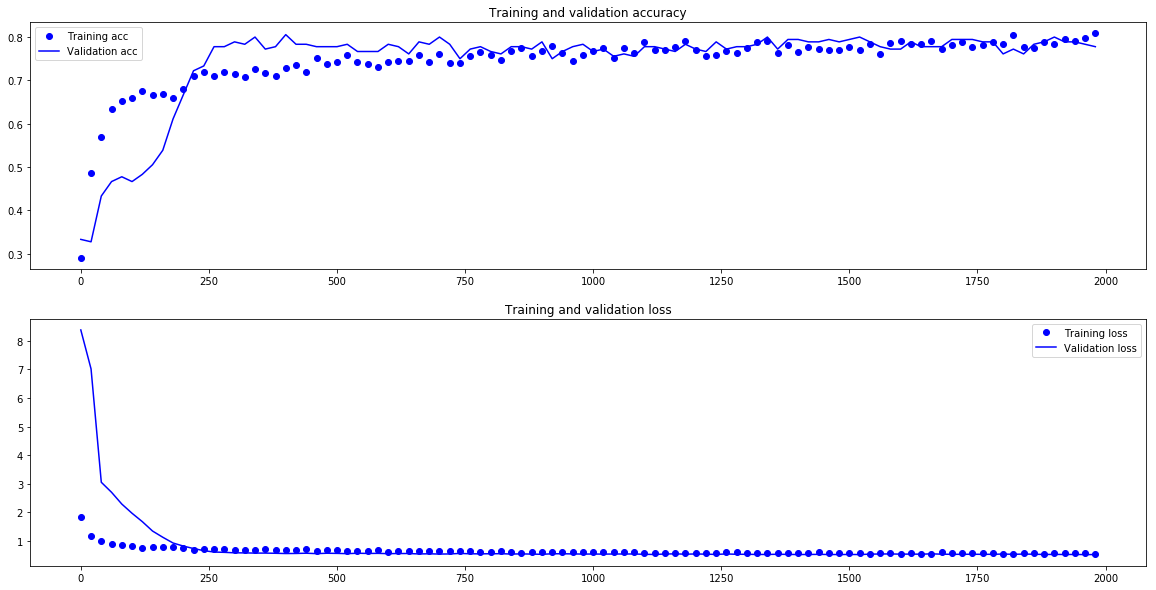

In [20]:
plot_history(history)

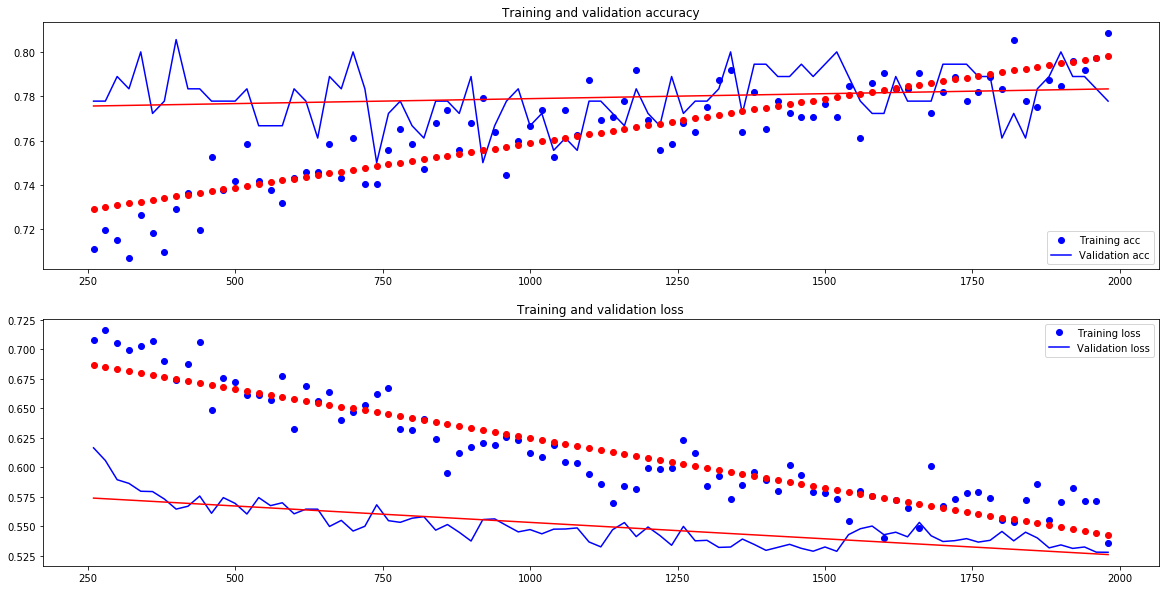

In [21]:
plot_history(history, init_phase_samples=250, plot_line=True)

### Scores around 80% look good now, there might even be a bit more potential here, but we are not going after a final percent here

## We now seem to have a decent model, so we save it for the next steps

In [22]:
model.save('insurance.hdf5')

In [23]:
# the model has a decent size as we only have a little more than 10.000 parameters
!ls -l insurance.hdf5

-rw-r--r-- 1 olive 197609 179704 Sep 13 08:50 insurance.hdf5
